<a href="https://colab.research.google.com/github/megan-the-astronomer/ASTR229/blob/main/intro_to_photometry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Measuring brightness with aperture photometry

In this notebook, we'll look at one of the simplest (but still widely-used) methods to measure the brightness of stars. Aperture photometry gives us a measure of the brightness of stars from the sum of the pixel counts in an aperture on the star, minus an estimate of the local sky.

Implementing this in practice can be complicated for several reasons, not least because a star's light is usually spread out over a few (usually square) pixels. Fortunately, many software packages have been written to implement aperture photometry.

In this notebook, we'll use astropy's ```photutils``` package. As always, it's a good idea to look at the documentation: https://photutils.readthedocs.io/en/stable/

In [ ]:
# start by importing the necessities
import numpy as np
from astropy.io import fits
from matplotlib import pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Visualizing stars in a digital image

Before we dig in to measurements, let's take a moment to visualize what a star looks like in our digital images.

In [ ]:
# read in the data
hdu = fits.open('/content/drive/MyDrive/ASTR230/example_data/NGC2264_reduced/NGC2264_V_long.fits')
image = hdu[0].data

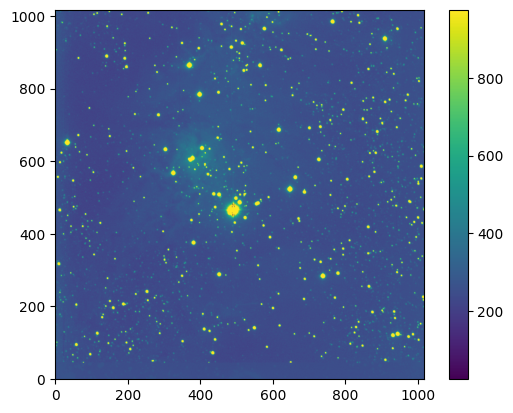

In [ ]:
plt.imshow(image, origin='lower', vmin=25, vmax=975)
plt.colorbar()


One can visualize a CCD image as a 3D surface, where the x,y plane is the pixel coordinates (that map to sky coordinates like RA and Dec) and the z-direction is the number of counts. An image of a star looks like a 'mountain'. To measure the brightness of a star, the goal is to measure the volume of the mountain - the total counts from the star. To do this we must also estimate the height of the 'plain' that the mountain sits on.

Let's display the image as a surface plot to illustrate this.

In [ ]:
xarray = np.vstack([np.arange(image.shape[1])]*image.shape[0])
yarray = np.tile(np.arange(image.shape[0])[:,np.newaxis], image.shape[1])

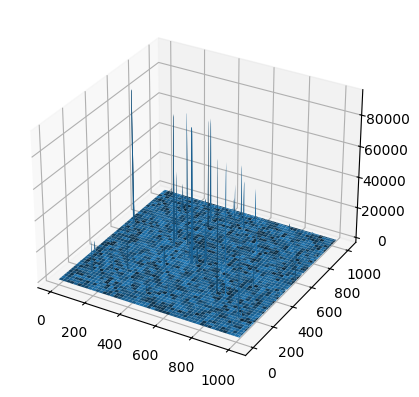

In [ ]:
# Plot the surface to visualize the 'mountains'
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(xarray, yarray, image)#, vmin=Z.min() * 2, cmap=cm.Blues)

Zoom in on one star to get a better view of the profile of the star.

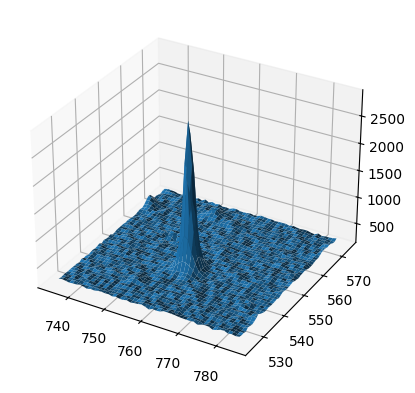

In [ ]:
# Plot the surface to visualize the 'mountains'
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(xarray[525:575,735:785], yarray[525:575,735:785], image[525:575,735:785])

# Source detection

We could attempt to identify the stars in our image by hand but this will be slow and painful for any image with more than a few stars. Source detection is clearly a good task to try to automate with a computer. However, the actual implementation of robust, efficient source detection is not necessarily straightforward.

Fortunately, there is existing software that we can use. In this example, we use the ```DAOStarFinder```, a time-tested algorithm which identifies local maxima that have a shape that is approximately a 2D Gaussian. For more details on how this works (and a good overview of the full process of aperture photometry), take a look at the original paper: [Stetson 1987](https://ui.adsabs.harvard.edu/abs/1987PASP...99..191S/abstract).

### Estimating the FWHM

Setting up source detection requires that we define two things:

1. The expected width of the star - the FWHM.

2. A noise threshold - the minimum signal above the background that a pixel must have to be considered part of an object.

We know that the seeing can vary during the night, so the best way to estimate the seeing is to measure the FWHM of a star of moderate brightness from the data itself.

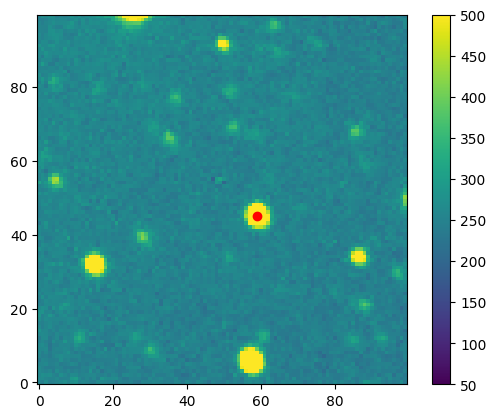

In [ ]:
# starting coordinates
xstar = 759
ystar = 545

# show only a portion of the image around the star so it is easier to see the star
plt.imshow(image[500:600,700:800], origin='lower', vmin=50, vmax=500)
# note: we trimmed the image so we have to correct to the new origin
plt.plot([xstar-700], [ystar-500], 'o', color='red')
plt.colorbar()

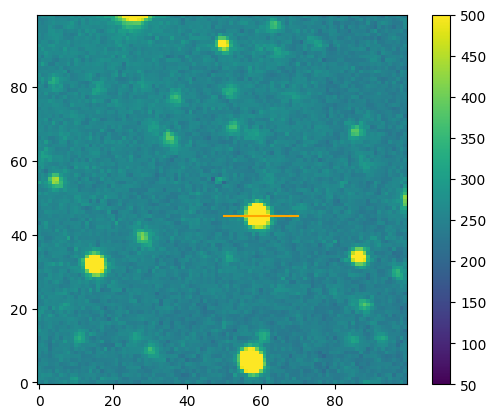

In [ ]:
# draw a line on the image to make sure it's where we want it to be
plt.imshow(image[500:600,700:800], origin='lower', vmin=50, vmax=500)
# note: we trimmed the image so the (x,y) values are relative to the new origin
plt.plot([50,70],[ystar-500,ystar-500], color='orange')
plt.colorbar()

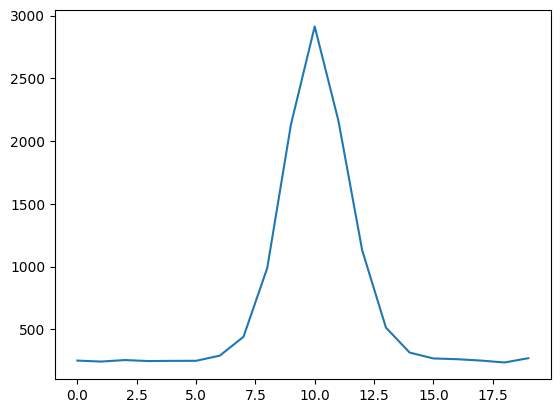

In [ ]:
# plot the slice through the star
plt.plot(image[ystar,xstar-10:xstar+10])

Careful! We just eyeballed the position of the star so this tracing does not necessarily go through the center of the star!

We can calculate the sub-pixel center of the star a few different ways. One approach is to calculate the center of light (analogous to calculating the center of mass). In one dimension, this is

\begin{equation}
\frac{\Sigma N_i x_i}{\Sigma N_i}
\end{equation}

where $N_i$ is the counts in pixel $i$ and $x_i$ is the pixel coordinate.

In [ ]:
# calculate the x and y centroids separately
xcntr = np.sum(np.arange(xstar-10,xstar+10)*image[ystar,xstar-10:xstar+10]) / np.sum(image[ystar,xstar-10:xstar+10])
ycntr = np.sum(np.arange(ystar-10,ystar+10)*image[ystar-10:ystar+10,xstar]) / np.sum(image[ystar-10:ystar+10,xstar])

In [ ]:
print(xcntr, ycntr)

758.8837570308 545.0528790741504


Ideally, we would use these precise sub-pixel positions to take a tracing through the true center of the star. This requires interpolating the measured flux to that position. For now, we'll look at the simpler case of the nearest integer pixel.

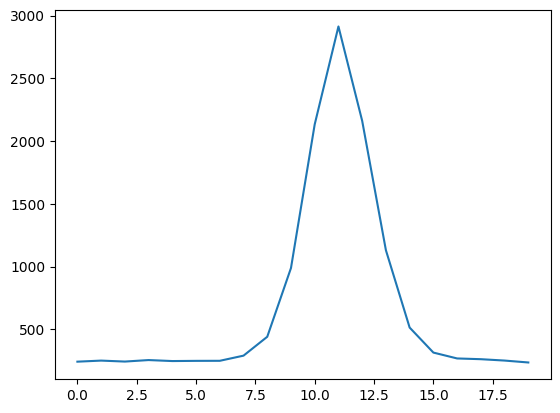

In [ ]:
plt.plot(image[ycntr.astype(int),xcntr.astype(int)-10:xcntr.astype(int)+10])

Fit a 1D Gaussian model to the radial profile in both the x and y directions.

In [ ]:
from astropy.modeling import models, fitting

# Fit the stellar profile with a 1D Gaussian
g_init = models.Gaussian1D(amplitude=1., mean=0, stddev=1.)
fit_g = fitting.TRFLSQFitter()

# define the x-coordinates on either side of the origin
xvals = np.arange(-10,10)
# normalize the star profile so the amplitude is ~1
norm_profile = image[ystar,xstar-10:xstar+10]/image[ystar,xstar-10:xstar+10].max()
# fit the Gaussian
g = fit_g(g_init, xvals, norm_profile)


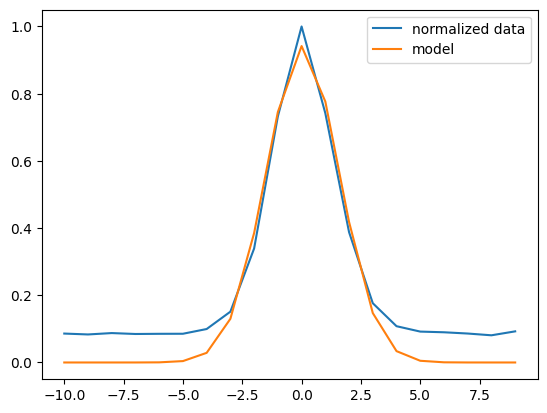

In [ ]:
plt.plot(xvals, norm_profile, label='normalized data')
plt.plot(xvals, g(xvals), label='model')
plt.legend()

We can use the results of the Gaussian fit to determine the subpixel center position and the FWHM of the star.

In [ ]:
g

<Gaussian1D(amplitude=0.94218373, mean=0.04813015, stddev=1.53161333)>

In [ ]:
fwhm = 2 * g.stddev * np.sqrt(2 * np.log(2))
fwhm

np.float64(3.6066737793334522)

Try fitting a 2D Gaussian too. How different is the estimated FWHM?

### Determining the threshold

Next, we need to determine a threshold. Pixels with values below this threshold are considered noise and excluded. Pixels with counts above this value are considered to have real signal and those pixels will be used in source detection. We will use the image statistics to determine the threshold value. We apply sigma clipping so that outliers in the data do not bias the results.

The example below uses the full image to demonstrate the technique **but you should select a portion of the image with no stars or galaxies!** (can you explain why?)

In [ ]:
from astropy.stats import sigma_clipped_stats

mean, median, std = sigma_clipped_stats(image, sigma=3.0)
print(f'Sky background: mean = {mean:.5g}, median = {median:.5g}, standard deviation = {std:.3g}')

Sky background: mean = 252.46, median = 249.83, standard deviation = 22


With the value of the FWHM and threshold determined, we can finally search for stars in the image.

### Star finding

In [ ]:
# find the stars
from photutils.detection import DAOStarFinder

# use the FWHM calculated above as the estimated FWHM for the data
# set a threshold that detected stars must be at least 5-sigma above the background
daofind = DAOStarFinder(fwhm=fwhm, threshold=5.*std)
sources=daofind.find_stars(image-median)
sources['id', 'xcentroid','ycentroid'].pprint()

 id      xcentroid          ycentroid     
---- ------------------ ------------------
   1   77.5702837069308 45.490446289684904
   2  300.7069338611488  45.63046942995725
   3 422.95007158877524  45.43530809498482
   4   648.035418355692  45.92788716707577
   5  831.2814126893595  45.67286773126147
   6   837.404898471342   45.7717200735631
   7  48.85035746203573  47.31758207713473
   8  440.6321205150178  47.38415381554594
   9 23.318796598053055  48.32948844689851
  10 1001.7421481141815  47.74340206844177
 ...                ...                ...
1548  44.44942250093362 1016.3343483012576
1549  85.61821688373544 1016.5112993423335
1550 420.83704417448183 1016.1444977834543
1551  485.1880914080372 1015.9610235938674
1552  821.5552115237773 1016.0820862994949
1553   881.447073408749 1016.3179309569915
1554  57.63881880349348 1016.4310088635337
1555  410.1343407182769 1016.6863332686056
1556 445.39610462070766 1016.6982245900491
1557  491.0245231084409 1016.4591827590659
Length = 15

Do a quick visual check to make sure that the detected sources mostly coincide with things that look like stars.

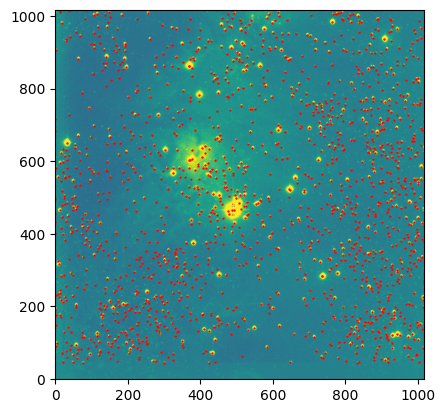

In [ ]:
plt.imshow(image, origin='lower', vmin=50, vmax=500)
plt.scatter(sources['xcentroid'], sources['ycentroid'], color='red', s=0.5)

This initial result looks pretty good but be sure to zoom in and inspect the results more closely. It is highly unlikely that automatic source detection did a perfect job identifying (only) real objects.

# Centroiding


The results of ```DAOStarFinder``` include its estimate of the center of each detected source. There are different ways of estimating the centroid and for some science cases a more precise estimate is very important.

One could naively estimate that the brightest pixel in a source represents its center. This can be biased by bad data (an unseen cosmic ray, saturated pixel core) and becomes a worse assumption for extended objects like galaxies. It is also imprecise because it provides only the integer pixel center.

We've already explored a couple of simple ways to determine the sub-pixel center of a star - computing the center of light and fitting a Gaussian profile.

We can use the ```centroids``` package in ```photutils``` to calculate centroids at scale. The package offers multiple algorithms to compute the centroid. You can read about some of the different options in the documentation: https://photutils.readthedocs.io/en/stable/reference/centroids_api.html.

Let's try an example using ```centroid_quadratic```.


In [ ]:
from photutils.centroids import centroid_quadratic
xycen = centroid_quadratic(image, xpeak=xstar, ypeak=ystar)
print(xycen)

[759.06280145 545.16449144]


Compare this to the center of light we computed.

In [ ]:
print(xcntr,ycntr)

758.8837570308 545.0528790741504


...and the center found by ```DAOStarFinder```.

In [ ]:
# calculate the radial distance of our star from all stars detected by DAOStarFinder
rad_dist = np.sqrt((sources['xcentroid'] - xstar)**2 + (sources['ycentroid'] - ystar)**2)
# find the minimum distance
idx = np.argmin(rad_dist)

In [ ]:
# print the coordinates to make sure we've selected the correct star
sources['xcentroid','ycentroid'][idx]

<Row index=882>
    xcentroid        ycentroid    
     float64          float64     
----------------- ----------------
759.0610389666143 545.265242599321

(535.0, 555.0)

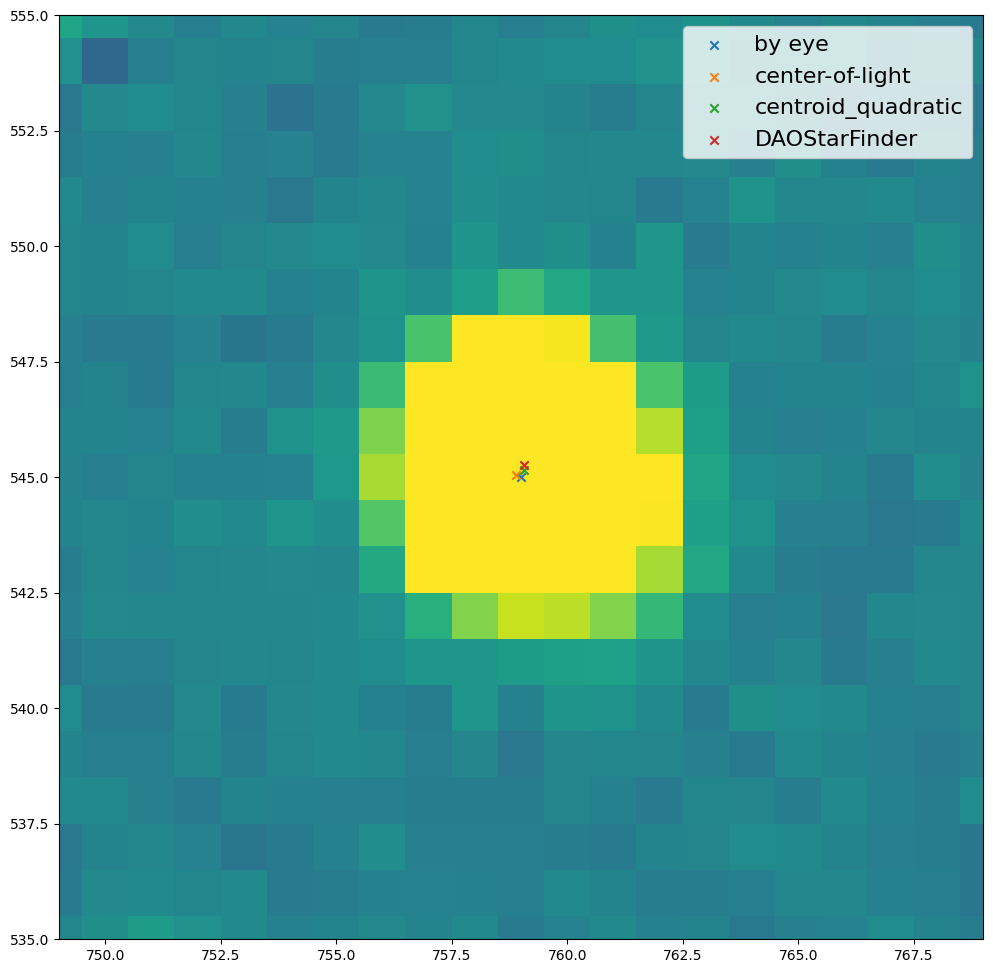

In [ ]:
# plot all the centroids on a super-zoomed in image to show the scatter
plt.figure(figsize=(12,12))
plt.imshow(image, origin='lower', vmin=50, vmax=500)
plt.scatter(xstar,ystar, marker='x', label='by eye')
plt.scatter(xcntr,ycntr, marker='x', label='center-of-light')
plt.scatter(xycen[0],xycen[1], marker='x', label='centroid_quadratic')
plt.scatter(sources['xcentroid'][idx],sources['ycentroid'][idx], marker='x', label='DAOStarFinder')
plt.legend(fontsize=16)

plt.xlim(xstar-10, xstar+10)
plt.ylim(ystar-10, ystar+10)

We can also use the centroid position to extract the radial profile of the star.

In [ ]:
from photutils.profiles import RadialProfile
edge_radii = np.arange(25)
rp = RadialProfile(image, xycen, edge_radii, mask=None)

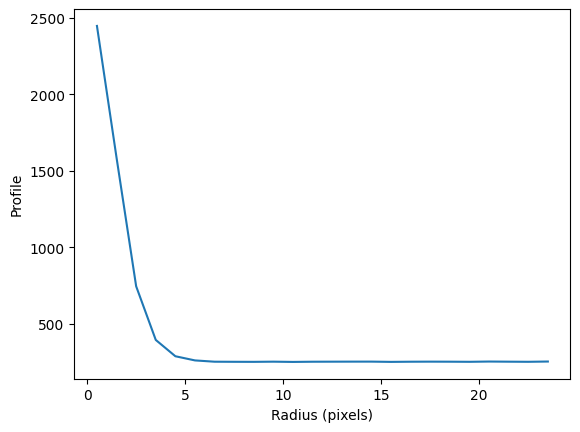

In [ ]:
rp.plot(label='Radial Profile')

Look familiar? Note that this is a radial profile, so it's only half the star. From this radial profile, it's easy to get the FWHM from a Gaussian fit.

In [ ]:
rp.gaussian_fwhm

np.float64(4.005896322950299)

Note that the FWHM is slightly different from what we calculated above because our simple estimate does not necessarily go through the true center of the star.

# Aperture photometry

Aperture photometry works by adding up all the counts in an aperture centered on the star (the mountain), and subtracting off the ‘average’ height of the background determined from the pixel values in an annulus around the star (the ‘plain’).

Let's go through the process step-by-step for our example star.

### Define the aperture and extract the signal

We'll use a circular aperture for this star-based example. Be sure to look at the documentation for ```photutils.aperture``` to see what other apertures are available: https://photutils.readthedocs.io/en/latest/user_guide/aperture.html

(500.0, 600.0)

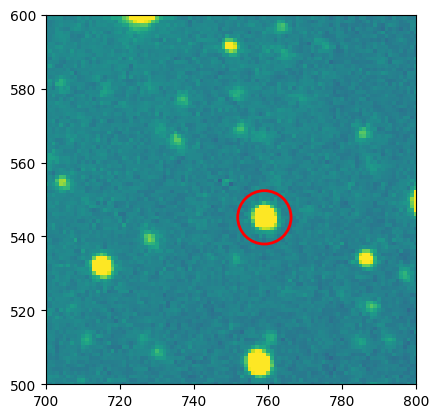

In [ ]:
from photutils.aperture import CircularAperture

# Define the aperture
aperture = CircularAperture(xycen, r=2*fwhm)

# Plot the aperture on top of the image
plt.imshow(image, origin='lower', vmin=50, vmax=500)
aperture.plot(color='red', lw=2, label='Aperture')
plt.xlim(700, 800)
plt.ylim(500, 600)

All we did in the previous step was define the aperture. Next, we'll use the ```aperture_photometry``` function to extract the counts.

In [ ]:
from photutils.aperture import aperture_photometry

# actually perform aperture photometry
phot_table = aperture_photometry(image - median, aperture)
print(phot_table)


 id     xcenter           ycenter         aperture_sum   
--- ---------------- ----------------- ------------------
  1 759.062801448129 545.1644914371167 32111.976200254096


The same basic process can be used to fit multiple apertures at once. Let's do this to make the plot of the number of counts as a function of the aperture size.

In [ ]:
# Define the apertures between 0.5 and 5 times the FWHM
radii = np.arange(0.5, 5, 0.25) * fwhm
apertures = [CircularAperture(xycen, r=r) for r in radii]

# Perform aperture photometry
phot_table = aperture_photometry(image - median, apertures)

print(phot_table)
print(phot_table.colnames)

 id     xcenter           ycenter      ...  aperture_sum_16    aperture_sum_17 
--- ---------------- ----------------- ... ------------------ -----------------
  1 759.062801448129 545.1644914371167 ... 33760.445926247776 34042.10134910573
['id', 'xcenter', 'ycenter', 'aperture_sum_0', 'aperture_sum_1', 'aperture_sum_2', 'aperture_sum_3', 'aperture_sum_4', 'aperture_sum_5', 'aperture_sum_6', 'aperture_sum_7', 'aperture_sum_8', 'aperture_sum_9', 'aperture_sum_10', 'aperture_sum_11', 'aperture_sum_12', 'aperture_sum_13', 'aperture_sum_14', 'aperture_sum_15', 'aperture_sum_16', 'aperture_sum_17']


Text(0, 0.5, 'Flux (ADU)')

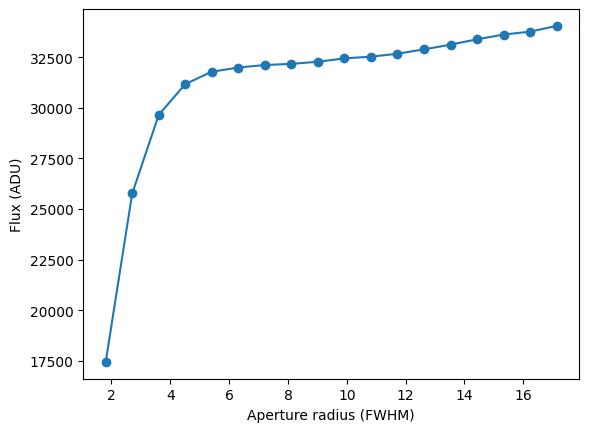

In [ ]:
# Get the region we are interested in from the table
region = phot_table[0]

# Convert the values to a list
region_data = list(region.values())

# Exclude the first three values, which are the id, x, and y coordinates
fluxes = region_data[3:]

# Plot the growth curve
plt.plot(radii, fluxes, marker='o')
plt.xlabel('Aperture radius (FWHM)')
plt.ylabel('Flux (ADU)')

This 'growth curve' measures the increase in flux as a function of the aperture size. Notice that it begins to level off but does not go completely flat. This is because each pixel still includes sky emission which will contribute to the total counts. The next step is to remove the local background to isolate the star light as much as possible.

### Determine the local background

If you looked carefully at the code, you may have noticed that we did the first measurements on the ```image - median```. This is in essense a very coarse estimate of the background. A better, more accurate estimate of the sky emission is measured locally using an annulus around the aperture.

The ```photutils.aperture``` package provides an easy way to setup a sky annulus.

(500.0, 600.0)

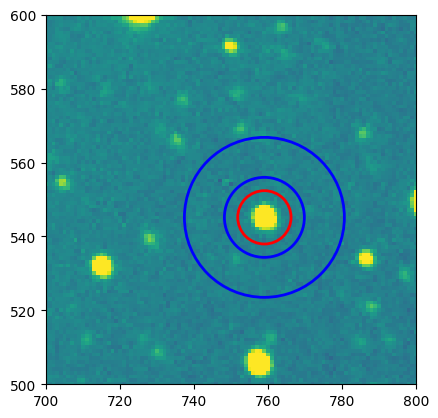

In [ ]:
from photutils.aperture import CircularAnnulus

# Define the annulus
annulus = CircularAnnulus(xycen, r_in=3*fwhm, r_out=6*fwhm)

# Plot the annulus
plt.imshow(image, origin='lower', vmin=50, vmax=500)
aperture.plot(color='red', lw=2, label='Aperture')
annulus.plot(color='blue', lw=2, label='Annulus')
plt.xlim(700, 800)
plt.ylim(500, 600)

Ideally, the annuli should be far enough from the star that they do not include any light from the target star but not so far that they no longer represent the local sky emission.

Next, we use the statistics in the sky annulus to come up with a representative sky background.

In [ ]:
from photutils.aperture import ApertureStats

annulus_stats = ApertureStats(image, annulus)
back = annulus_stats.median
std = annulus_stats.std
print(f'Background per pixel: {back:.3f}')

Background per pixel: 251.659


Notice that we are using the median, not the mean! The mean will be affected by outliers - like another star that falls in the sky annulus - more so than the median.

The median value in the annulus gives the expected background emission *per pixel*, so we need to multiply that by the area of the aperture to determine the total amount of sky emission to subtract from the star.

In [ ]:
phot_table = aperture_photometry(image, aperture)
flux = phot_table['aperture_sum'][0]
aperture_area = aperture.area_overlap(image)
flux_no_back = flux - back * aperture_area

print(f'Flux (raw): {flux:.3f}')
print(f'Background: {back:.3f}')
print(f'Area: {aperture_area:.3f}')
print(f'Flux (without background): {flux_no_back:.3f}')

Flux (raw): 72950.383
Background: 251.659
Area: 163.465
Flux (without background): 31812.992


A few things to note:
 - the flux (counts) should be much lower after you subtract the background.
 - the difference may be even more dramatic in data taken with RUCO as the sky background is significantly higher in the center of Houston than it is in west Texas!

### Performing aperture photometry for many stars at once

Most of the same steps we just performed for our example star can be done for many stars at once.

To start, take a look at the output from ```DAOStarFinder``` again. We only looked at the first three columns earlier but there is a lot more information in the full table.

In [ ]:
sources

<QTable length=1557>
  id      xcentroid      ...         mag             daofind_mag     
int64      float64       ...       float64             float64       
----- ------------------ ... ------------------- --------------------
    1   77.5702837069308 ...  -9.530190715750814  -2.3898457441483445
    2  300.7069338611488 ...  -8.760668202518774   -1.721299107483366
    3 422.95007158877524 ...  -9.168876625815564  -2.2456724061843234
    4   648.035418355692 ... -11.472106147325139   -4.435269425329406
    5  831.2814126893595 ...  -8.386358182549925  -1.4067551664757265
    6   837.404898471342 ...  -7.999576538839365  -0.6243345023623791
    7  48.85035746203573 ...   -9.42826304949895  -1.9363990986169193
    8  440.6321205150178 ... -7.5350248433597535 -0.46293632581078265
    9 23.318796598053055 ...  -8.143775520825372 -0.48122326366342955
  ...                ... ...                 ...                  ...
 1548  44.44942250093362 ... -10.855506036089729   -3.526921325047612
 1549  85.61821688373544 ...  -7.319680702530535 -0.42856721661215796
 1550 420.83704417448183 ... -12.203236113822175   -4.891659194966321
 1551  485.1880914080372 ...   -8.40000583712782  -1.0010607662669726
 1552  821.5552115237773 ...  -8.236851439806312  -0.7284029506829353
 1553   881.447073408749 ...  -9.516656276602138   -2.221180059639568
 1554  57.63881880349348 ...  -7.070412907003407 -0.07670835780458886
 1555  410.1343407182769 ...  -9.050038588948699   -2.012916449204968
 1556 445.39610462070766 ...  -7.636046237225461  -0.4932941982727016
 1557  491.0245231084409 ...  -8.697889403604243  -1.3408449824526132

Notice that there are several other parameters, including sharpess and roundness estimates for all sources. These parameters can be a great way to further filter the list of detected objects to identify things that are highly likely to be stars. You can also play around with these parameters to see if changing their limits results in a better or worse selection of things that actually look like (single) stars. Better yet, plot out these parameters. Do the sharpness and roundness values tend to cluster around a particular number?

Once you are happy with your list of probable stars, we can go through the same steps we did for one star to perform photometry on many sources at once.

In [ ]:
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))

 ...]

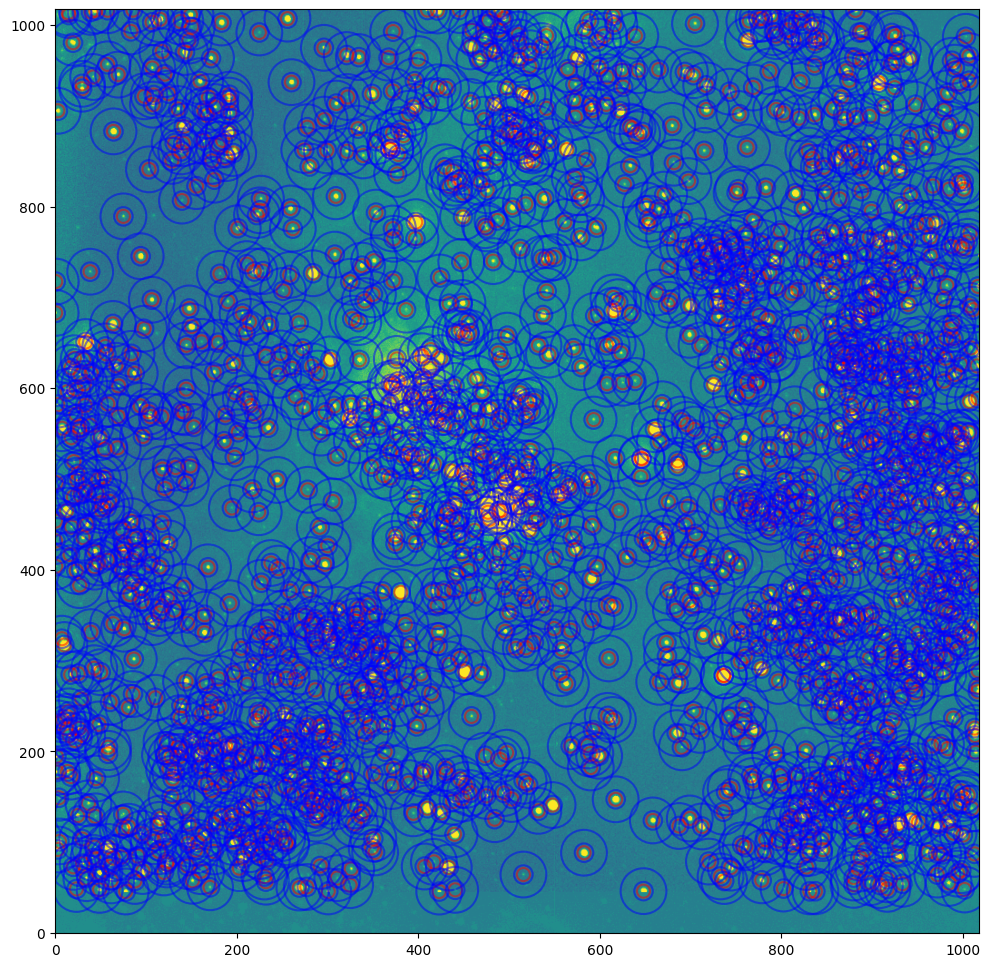

In [ ]:
# define the aperture
r_a = 2*fwhm
apertures = CircularAperture(positions, r=r_a)

# define the annulus
r_in = r_a + 3
r_out = r_in + 15
annulus = CircularAnnulus(positions, r_in=r_in, r_out=r_out)

# display the image
plt.figure(figsize=(12,12))
plt.imshow(image, origin='lower', vmin=50, vmax=500)

# plot the aperture and the annulus for each source
apertures.plot(color='red', lw=1.5, alpha=0.5)
annulus.plot(color='blue',lw=1.5, alpha=0.5)

In [ ]:
phot_table = aperture_photometry(image, apertures)
phot_table

<QTable length=1557>
  id       xcenter            ycenter          aperture_sum   
int64      float64            float64            float64      
----- ------------------ ------------------ ------------------
    1   77.5702837069308 45.490446289684904  49874.42329417299
    2  300.7069338611488  45.63046942995725 44338.532662410274
    3 422.95007158877524  45.43530809498482 45515.110377891186
    4   648.035418355692  45.92788716707577  83362.34815021143
    5  831.2814126893595  45.67286773126147  45681.86239608489
    6   837.404898471342   45.7717200735631  45570.14002574596
    7  48.85035746203573  47.31758207713473  48786.80237219763
    8  440.6321205150178  47.38415381554594  39861.37145839927
    9 23.318796598053055  48.32948844689851   45818.2987853244
  ...                ...                ...                ...
 1548  44.44942250093362 1016.3343483012576  58958.10577344255
 1549  85.61821688373544 1016.5112993423335  23589.42989447919
 1550 420.83704417448183 1016.1444977834543  116109.7343179345
 1551  485.1880914080372 1015.9610235938674  32119.35442359341
 1552  821.5552115237773 1016.0820862994949  28768.36985393475
 1553   881.447073408749 1016.3179309569915  31585.73324336081
 1554  57.63881880349348 1016.4310088635337  24178.41527919449
 1555  410.1343407182769 1016.6863332686056 29926.329267655503
 1556 445.39610462070766 1016.6982245900491 25992.320204365617
 1557  491.0245231084409 1016.4591827590659  31448.20357703499

In [ ]:
aperstats = ApertureStats(image, annulus)

In [ ]:
phot_table['median_bkg'] = aperstats.median
phot_table

<QTable length=1557>
  id       xcenter       ...    aperture_sum        median_bkg    
int64      float64       ...      float64            float64      
----- ------------------ ... ------------------ ------------------
    1   77.5702837069308 ...  49874.42329417299 254.21456668214495
    2  300.7069338611488 ... 44338.532662410274 244.49300688643302
    3 422.95007158877524 ... 45515.110377891186 244.49300688643302
    4   648.035418355692 ...  83362.34815021143 244.49300688643302
    5  831.2814126893595 ...  45681.86239608489 252.38700929830344
    6   837.404898471342 ...  45570.14002574596 253.34985826168796
    7  48.85035746203573 ...  48786.80237219763 263.75294598430673
    8  440.6321205150178 ...  39861.37145839927 244.49300688643302
    9 23.318796598053055 ...   45818.2987853244 272.66087881083513
  ...                ... ...                ...                ...
 1548  44.44942250093362 ...  58958.10577344255  244.7859082761318
 1549  85.61821688373544 ...  23589.42989447919 236.31465703349352
 1550 420.83704417448183 ...  116109.7343179345  260.5267787565394
 1551  485.1880914080372 ...  32119.35442359341  261.1813086259027
 1552  821.5552115237773 ...  28768.36985393475 255.32811383194553
 1553   881.447073408749 ...  31585.73324336081  245.2689538820436
 1554  57.63881880349348 ...  24178.41527919449 240.57041734925122
 1555  410.1343407182769 ... 29926.329267655503   253.920272738182
 1556 445.39610462070766 ... 25992.320204365617 264.40017749447725
 1557  491.0245231084409 ...  31448.20357703499  263.8244359474964

In [ ]:
bkg_contribution = phot_table['median_bkg'] * apertures.area
source_counts = phot_table['aperture_sum'] - bkg_contribution

In [ ]:
phot_table['bkg_tot'] = bkg_contribution
phot_table['src_counts'] = source_counts

From here, you should be able to calculate instrumental magnitudes. Don't forget to divide by the exposure time to get the count rate instead of the total number of counts!

To flux calibrate the data, you'll want to correct for atmospheric extinction. Recall that the extinction correction is $k\sec{z}$. For this exercise, assume that $k=1$. You can look up the airmass of observation in the image header. Note that it's always a good idea to make note to the airmass in your observing log too because header information can be wrong!

In [ ]:
header = fits.open('/content/drive/MyDrive/my_ASTR229_data/m82/obj0068.fits')[0].header

In [ ]:
header['EXPTIME']

60.0

In [ ]:
header['AIRMASS']

1.311